### Key takeaways from the paper

The system uses neural representations to separate and recombine content and style of arbitrary images, providing a neural algorithm for the creation of artistic images.

The key finding of this paper is that the representations of content and style in the Convolutional
Neural Network are separable. That is, we can manipulate both representations independently
to produce new, perceptually meaningful images.

#### What is a content of Image ? 

When Convolutional Neural Networks are trained on object recognition, they develop a
representation of the image that makes object information increasingly explicit along the processing
hierarchy.8 Therefore, along the processing hierarchy of the network, the input image
is transformed into representations that increasingly care about the actual content of the image
compared to its detailed pixel values. We can directly visualise the information each layer
contains about the input image by reconstructing the image only from the feature maps in that
layer9 (Fig 1, content reconstructions, see Methods for details on how to reconstruct the image).
Higher layers in the network capture the high-level content in terms of objects and their
arrangement in the input image but do not constrain the exact pixel values of the reconstruction.
(Fig 1, content reconstructions d,e). In contrast, reconstructions from the lower layers
simply reproduce the exact pixel values of the original image (Fig 1, content reconstructions
a,b,c). We therefore refer to the feature responses in higher layers of the network as the content
representation.

#### What is a style of an Image ? 

### Implementation

#### Import Dependencies

In [15]:
%matplotlib inline

In [45]:
from keras.models import Model, Sequential 
import numpy as np 
from PIL import Image 
from keras import backend as K 
import keras 
import scipy
import matplotlib.pyplot as plt

In [17]:
from vgg16_avg import VGG16_Avg

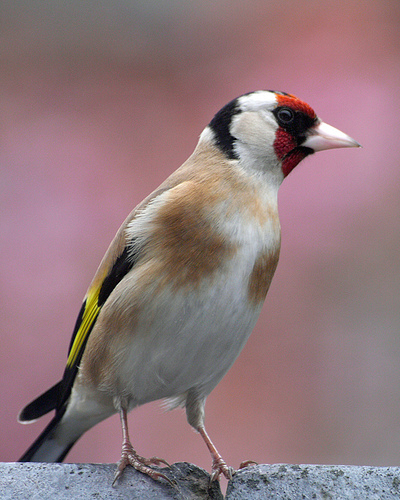

In [18]:
content_image_raw = Image.open('C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer\\img\\n01531178_23017.JPEG');
content_image_raw

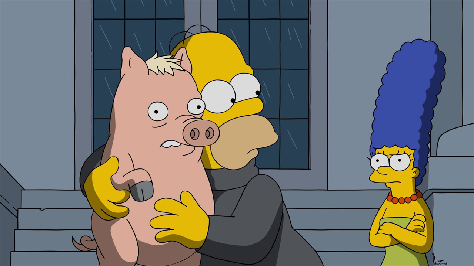

In [19]:
style_image_raw = Image.open('C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer\\img\\simpson.png');
style_image_raw

#### Preprocessing Functions 

In [20]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

In [21]:
preproc = lambda x: (x-vgg_mean)[:,:,:,::-1]

In [22]:
depreproc = lambda x,s: np.clip(x.reshape(s)[:,:,:,::-1] + vgg_mean ,0,255) 

In [23]:
content = preproc(np.expand_dims(np.array(content_image_raw),0))
content_shape = content.shape

In [24]:
style = preproc(np.expand_dims(np.array(style_image_raw),0))
style_shape = style.shape

#### Content  

In [25]:
model = VGG16_Avg(include_top = False)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [27]:
layer = model.get_layer('block5_conv1').output

In [28]:
content_model = Model(model.input, layer)

In [29]:
content_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [36]:
targ = K.variable(content_model.predict(content))

In [37]:
targ.shape

TensorShape([Dimension(1), Dimension(31), Dimension(25), Dimension(512)])

In [39]:
loss = K.mean(keras.metrics.mse(layer,targ))
grads = K.gradients(loss,content_model.input)

In [40]:
class Evaluator(object):
    
    def __init__(self,f,shp): self.f, self.shp = f, shp
    
    def loss(self,x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [41]:
fn = K.function([content_model.input], [loss]+grads)
evaluator = Evaluator(fn,content_shape)

In [49]:
def solve_content_image(eval_obj,niter, x):
    for i in range(niter):
        x, min_val, info = scipy.optimize.fmin_l_bfgs_b(eval_obj.loss, x.flatten(), 
                                                   fprime= eval_obj.grads, maxfun = 20)
        x = np.clip(x,-127,127)
        print('Current Loss is {}'.format(min_val))
        scipy.misc.imsave('Content_at_iter_{}.jpg'.format(i), depreproc(x.copy(),content_shape)[0])
    return x

In [97]:
iterations = 10

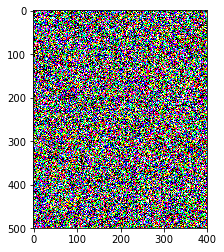

In [98]:
rand_img = lambda shape: np.random.uniform(-2.5,2.5,shape)/100
x = rand_img(content_shape)
plt.imshow(x[0])

In [99]:
x.shape

(1, 500, 400, 3)

In [100]:
x = solve_content_image(evaluator, iterations, x)

Current Loss is 49.13011169433594
Current Loss is 13.492116928100586
Current Loss is 7.040372371673584
Current Loss is 4.648168087005615
Current Loss is 3.551623582839966
Current Loss is 2.9222588539123535
Current Loss is 2.534470319747925
Current Loss is 2.2254042625427246
Current Loss is 1.9999443292617798
Current Loss is 1.8226172924041748


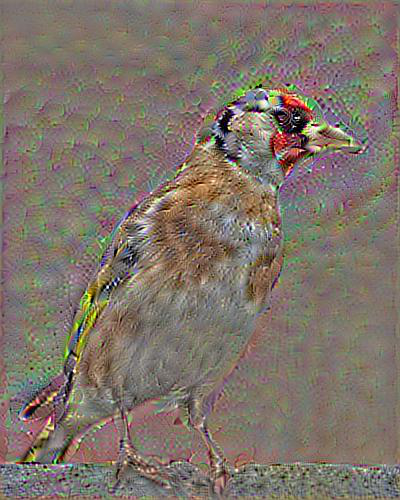

In [101]:
Image.open('Content_at_iter_9.jpg')

#### Style 

In [70]:
model = VGG16_Avg(include_top = False, input_shape = style_shape[1:])

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 266, 474, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 266, 474, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 266, 474, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 133, 237, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 133, 237, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 133, 237, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 66, 118, 128)      0         
__________

In [72]:
layers = {l.name:l.output for l in model.layers}

In [73]:
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_4/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_4/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_4/AvgPool:0' shape=(?, 133, 237, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_4/Relu:0' shape=(?, 133, 237, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_4/Relu:0' shape=(?, 133, 237, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_4/AvgPool:0' shape=(?, 66, 118, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_4/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_4/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_4/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_4/AvgPool:0' shape=(?, 33, 59, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_4/Relu:0' shape=(?, 33, 59, 512) d

In [74]:
layers_wanted = ['block1_conv1','block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [75]:
outputs = [layers[l] for l in layers_wanted]

In [76]:
outputs

[<tf.Tensor 'block1_conv1_4/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_4/Relu:0' shape=(?, 133, 237, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_4/Relu:0' shape=(?, 66, 118, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_4/Relu:0' shape=(?, 33, 59, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_4/Relu:0' shape=(?, 16, 29, 512) dtype=float32>]

In [77]:
style_model = Model(model.input, outputs)

In [78]:
style_targs = [K.variable(o) for o in style_model.predict(style)]

In [79]:
style_targs

[<tf.Variable 'Variable_6:0' shape=(1, 266, 474, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(1, 133, 237, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(1, 66, 118, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(1, 33, 59, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(1, 16, 29, 512) dtype=float32_ref>]

In [80]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [81]:
def style_loss(x, targ): return K.mean(keras.metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [82]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(outputs,style_targs))

In [83]:
grads = K.gradients(loss, model.input)

In [84]:
style_fn = K.function([model.input], [loss]+grads)
style_evaluator = Evaluator(style_fn, style_shape)

In [91]:
x = rand_img(style_shape)

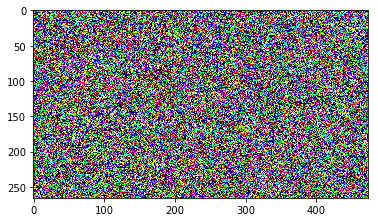

In [92]:
plt.imshow(x[0])

In [95]:
def solve_style_image(eval_obj,niter, x):
    for i in range(niter):
        x, min_val, info = scipy.optimize.fmin_l_bfgs_b(eval_obj.loss, x.flatten(), 
                                                   fprime= eval_obj.grads, maxfun = 20)
        x = np.clip(x,-127,127)
        print('style Loss is {}'.format(min_val))
        scipy.misc.imsave('style_at_iter_{}.jpg'.format(i), depreproc(x.copy(),style_shape)[0])
    return x

In [96]:
x = solve_style_image(style_evaluator, iterations, x)

style Loss is 70.68099212646484
style Loss is 63.3933219909668
style Loss is 56.79617691040039
style Loss is 51.61277389526367
style Loss is 47.38547897338867
style Loss is 43.858436584472656
style Loss is 40.8763313293457
style Loss is 38.32170486450195
style Loss is 36.070743560791016
style Loss is 34.1133918762207


#### Style Transfer 

In [103]:
def plot_arr(arr): plt.imshow(depreproc(arr,arr.shape)[0].astype('uint8'))

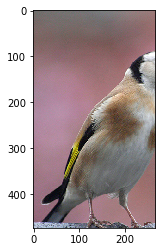

In [124]:
_,w,h,_ = style_shape
src = content[:,:h,:w]
plot_arr(src)

In [133]:
src.shape

(1, 474, 266, 3)

In [126]:
model = VGG16_Avg(include_top= False, input_shape = style_shape[1:])

In [127]:
outputs = {l.name:l.output for l in model.layers}

In [128]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]

In [129]:
content_layer = outputs['block4_conv2']

In [130]:
style_model_transfer = Model(model.input, style_layers)

In [131]:
style_targs = [K.variable(o) for o in style_model_transfer.predict(style)]

In [132]:
content_model_transfer = Model(model.input,content_layer)
content_targ = K.variable(content_model_transfer.predict(src))

ValueError: Error when checking : expected input_7 to have shape (None, 266, 474, 3) but got array with shape (1, 474, 266, 3)